In [1]:
################################################################################
#######################    Time series decomposition    ########################
################################################################################
### Load necessary modules -------------------------------
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import math
plt.style.use('ggplot')
plt.rcParams.update({'figure.figsize': (10, 7), 'figure.dpi': 120})
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage, cut_tree
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans
import unsupervisedtools as UT
import matplotlib.cm as cm

In [2]:
# Import data
df = pd.read_csv('Aggregation.dat', sep='\t', header=None)
df = df.loc[:,0:1]
df.columns = ['X1','X2']
df.head()

,X1,X2
0,15.55,28.65
1,14.90,27.55
2,14.45,28.35
3,14.15,28.80
4,13.75,28.05


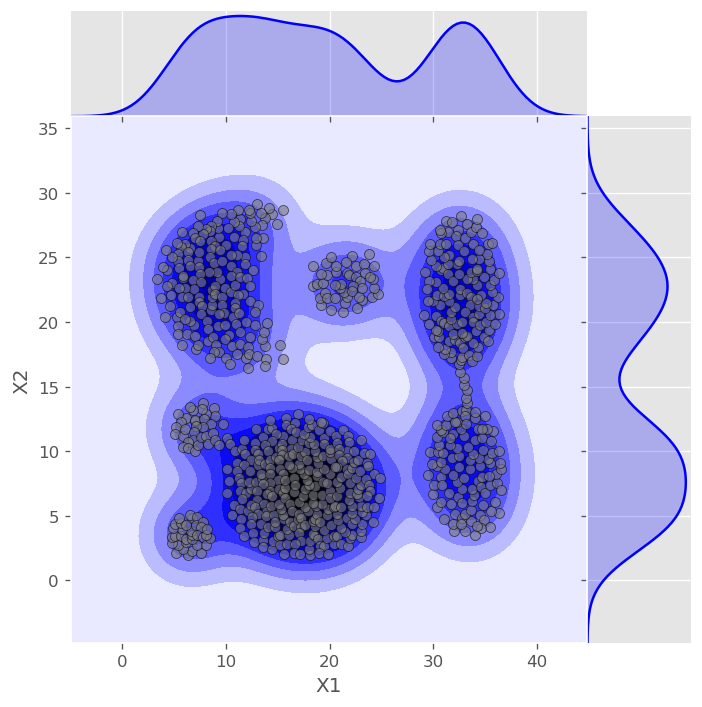

In [3]:
# Check relations between X1 and X2
g = sns.jointplot(data=df, x='X1', y='X2', kind='kde', space=0, color='blue') #, bw=7)
g.ax_joint.scatter(df.X1, df.X2, c='gray', edgecolor='black', alpha=0.6) # Add points to the 2d-density plot
plt.show()

In [4]:
# Preprocessing the values to perform PCA
numeric_features = df.select_dtypes(include=['int64','float64']).columns.values.tolist()
scaler = StandardScaler()
X_transformed = scaler.fit_transform(X=df)

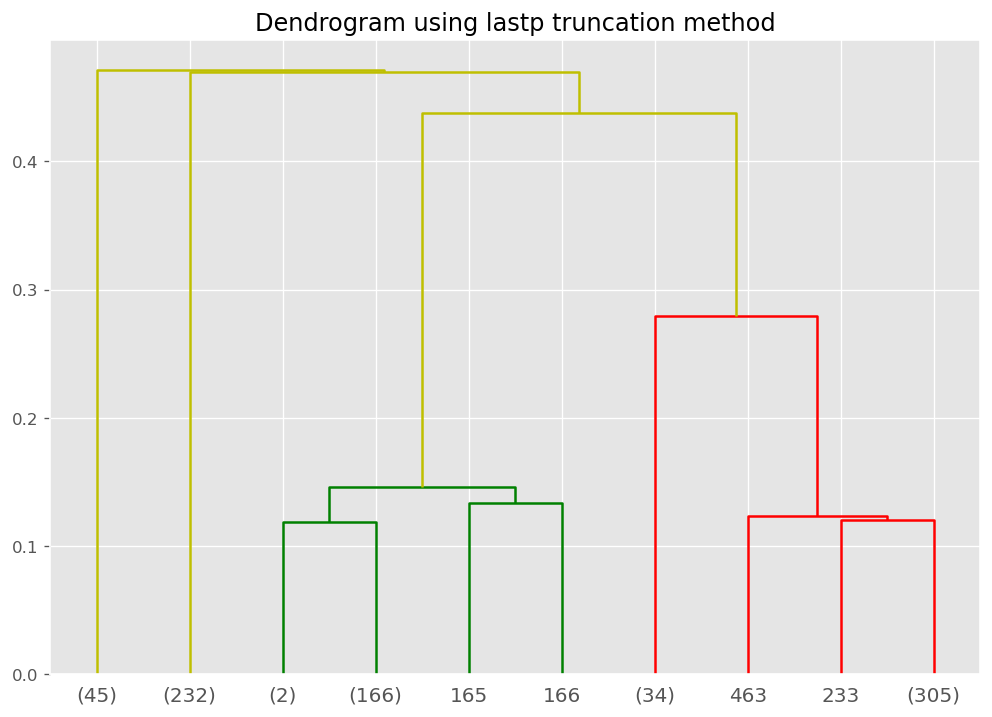

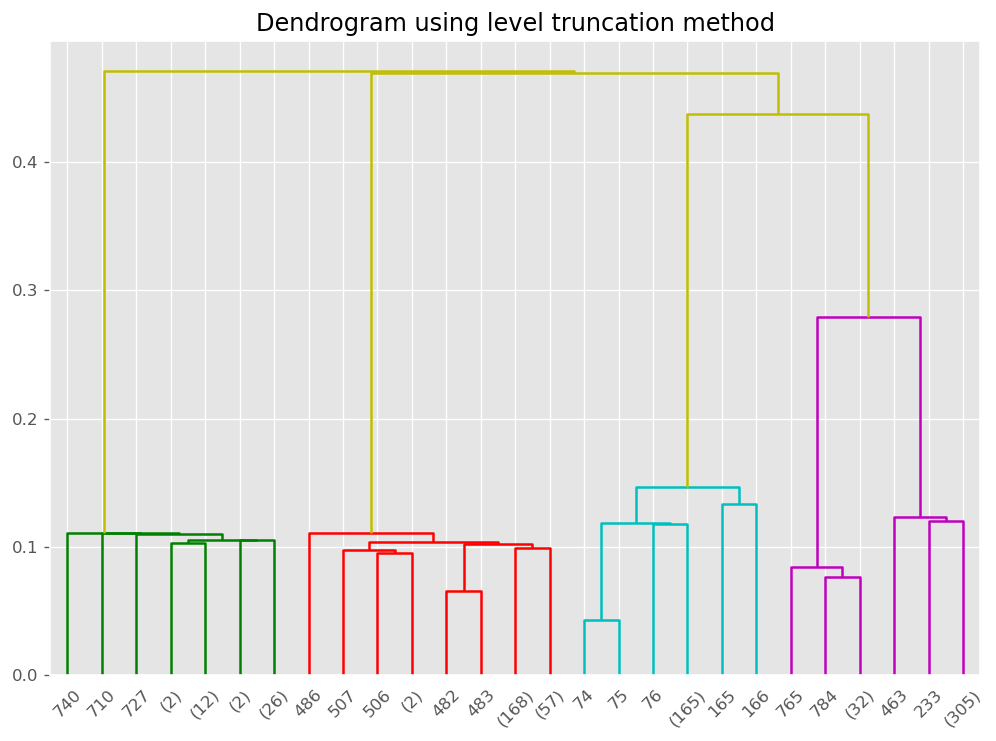

In [5]:
## Hierarchical clustering -------------------------------------------------------------------------------------------------------
# hierarchical clustering
linked = linkage(X_transformed, 'single')

plt.figure(figsize=(10, 7))
dendrogram(linked,
            orientation='top',
            labels=df.index, # labels of the rows
            truncate_mode= 'lastp', # Type of truncation, in this case number of leaves
            p = 10, # Number of leaves to show
            above_threshold_color='y', # Differentiate color above threshold
            color_threshold=0.4,
            distance_sort='descending',
            show_leaf_counts=True)
plt.gca().set_title('Dendrogram using lastp truncation method')
plt.show()

plt.figure(figsize=(10, 7))
dendrogram(linked,
            orientation='top',
            labels=df.index,
            truncate_mode= 'level', # Type of truncation, in this case number of levels. A “level” includes all nodes with p merges from the last merge.
            p = 5, # Number of leaves to show
            above_threshold_color='y',
            color_threshold=0.4,
            distance_sort='descending',
            show_leaf_counts=True)
plt.gca().set_title('Dendrogram using level truncation method')
plt.show()

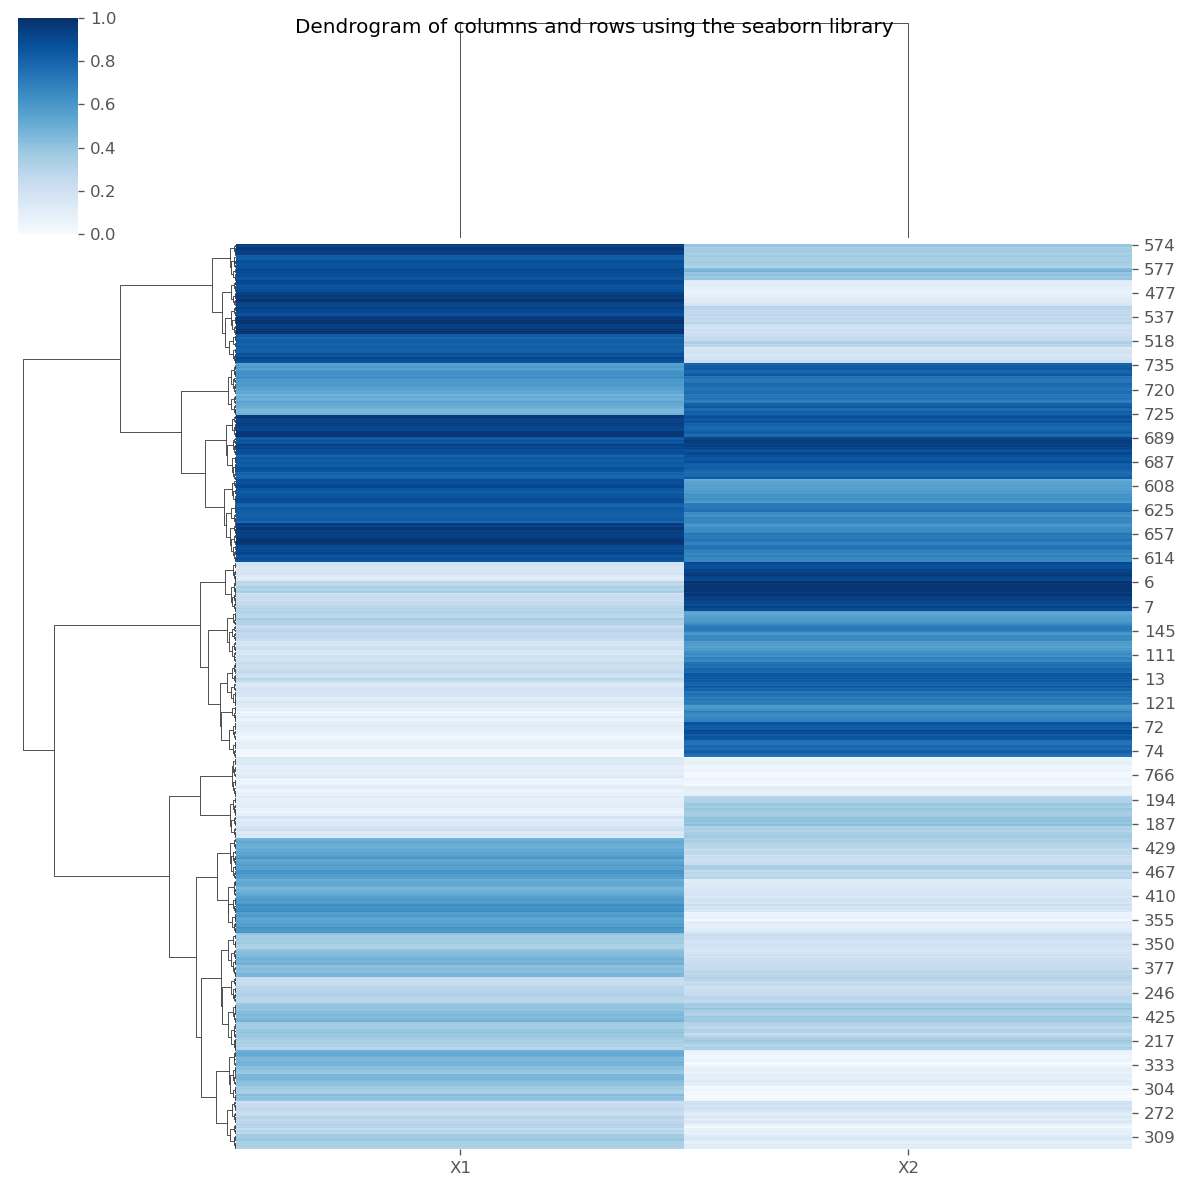

In [6]:
#Another view of the dendrograms using seaborn
# sns.clustermap(df) # default
# sns.clustermap(df, standard_scale=1) # Standardize data
# sns.clustermap(df, z_score=1) # Normalize data
# sns.clustermap(df, metric="euclidean", standard_scale=1) # Using euclidean distance
# sns.clustermap(df, metric="euclidean", standard_scale=1, method="ward") # Changing the cluster method
# sns.clustermap(df, metric="euclidean", standard_scale=1, method="ward", cmap="Blues") # Changing the color to be more appealing
# sns.clustermap(df, robust=True) # Use automatic outlier detection
sns.clustermap(df, metric="euclidean", standard_scale=1, method="ward", cmap="Blues").fig.suptitle('Dendrogram of columns and rows using the seaborn library')
plt.show()

In [7]:
# Cut dendrogram tree by number of clusters
cluster_nclust = cut_tree(linked, n_clusters=[4])
print('Clusters specifying number of clusters:')
unique, counts = np.unique(cluster_nclust, return_counts=True)
print(pd.DataFrame(np.asarray(counts), index=unique, columns=['# Samples']))
# Cut dendrogram tree by height
cluster_height = cut_tree(linked, height=[0.2])
print('Clusters specifying height:')
unique, counts = np.unique(cluster_height, return_counts=True)
print(pd.DataFrame(np.asarray(counts), index=unique, columns=['# Samples']))

Clusters specifying number of clusters:
   # Samples
0        170
1        341
2        232
3         45
Clusters specifying height:
   # Samples
0        170
1        307
2        232
3         45
4         34


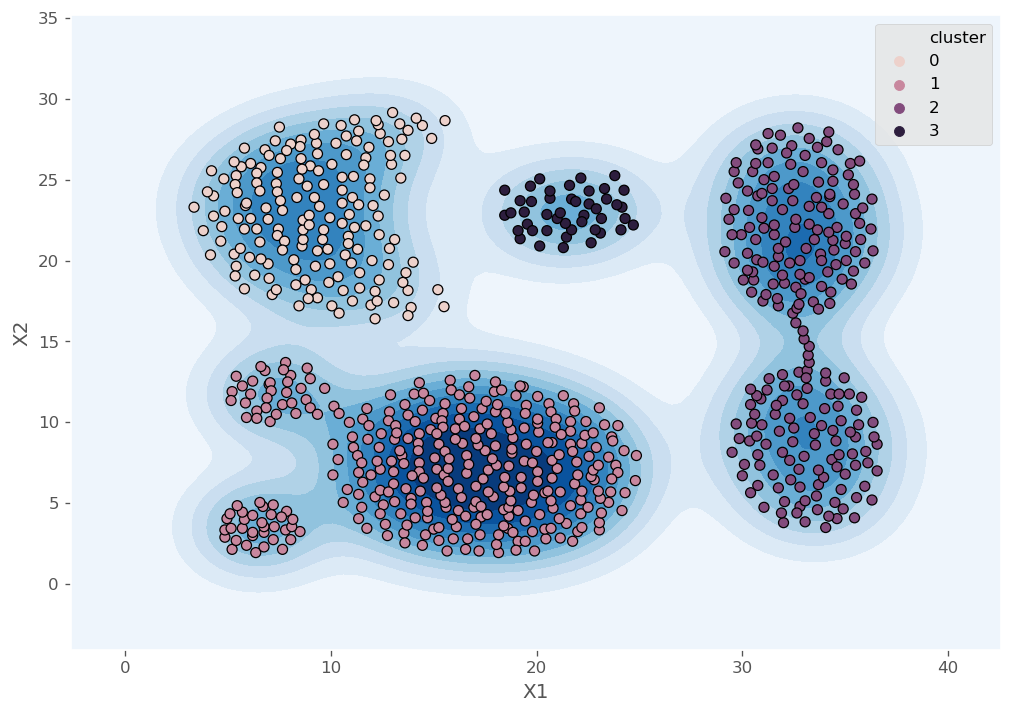

In [8]:
# Plot clustering classification
df_plot = df.copy()
df_plot['cluster'] = cluster_nclust
f, ax = plt.subplots(figsize=(10, 7))
sns.kdeplot(df_plot.X1, df_plot.X2, ax=ax, cmap="Blues", shade=True, bw=2)
sns.scatterplot(x='X1', y='X2', data=df_plot, hue='cluster', edgecolor='black', legend='full')
plt.show()

In [9]:
## Silhouette method ---------------
# Cut dendrogram tree by number of clusters
n_clusters = 4
cluster_labels = cut_tree(linked, n_clusters=n_clusters)
silhouette_avg = silhouette_score(X_transformed, cluster_labels)
print("For n_clusters =", n_clusters,
        "The average silhouette_score is :", silhouette_avg)
# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(X_transformed, cluster_labels)

For n_clusters = 4 The average silhouette_score is : 0.44888631766542825


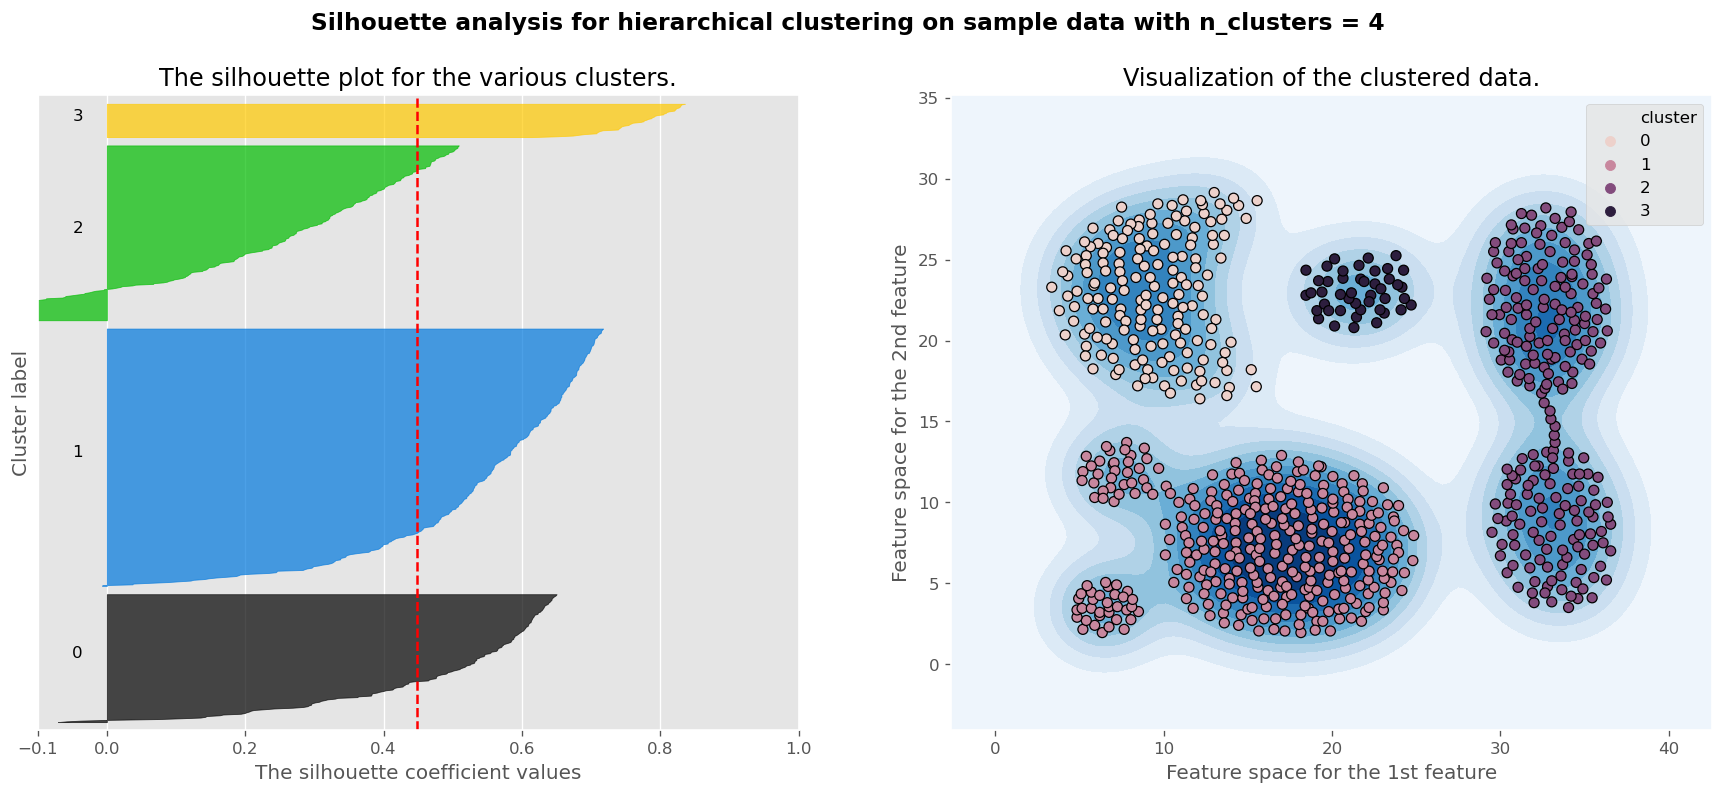

In [10]:
# Plot silhouette and real clusters
# Create a subplot with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)

# The 1st subplot is the silhouette plot
# The silhouette coefficient can range from -1, 1 but in this example all
# lie within [-0.1, 1]
ax1.set_xlim([-0.1, 1])
# The (n_clusters+1)*10 is for inserting blank space between silhouette
# plots of individual clusters, to demarcate them clearly.
ax1.set_ylim([0, len(X_transformed) + (n_clusters + 1) * 10])
y_lower = 10
for i in range(n_clusters):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    samples_cluster = cluster_labels == i
    ith_cluster_silhouette_values = sample_silhouette_values[samples_cluster[:,0]]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                        0, ith_cluster_silhouette_values,
                        facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

ax1.set_title("The silhouette plot for the various clusters.")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

# 2nd Plot showing the actual clusters formed
df_plot = df.copy()
df_plot['cluster'] = cluster_labels
sns.kdeplot(df_plot.X1, df_plot.X2, ax=ax2, cmap="Blues", shade=True, bw=2)
sns.scatterplot(x='X1', y='X2', data=df_plot, hue='cluster', edgecolor='black', legend='full', ax=ax2)

ax2.set_title("Visualization of the clustered data.")
ax2.set_xlabel("Feature space for the 1st feature")
ax2.set_ylabel("Feature space for the 2nd feature")

plt.suptitle(("Silhouette analysis for hierarchical clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
plt.show()

In [11]:
## K_means and silhouette method simultaneously with different number of clusters
range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X_transformed) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X_transformed)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_transformed, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X_transformed[:, 0], X_transformed[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

NameError: name 'X' is not defined